# PIP Install Magic and Libraries

In [1]:
#!pip install open-clip-torch==2.12.0
#!pip install numpy==1.22.4
#!pip install pandas==1.3.5
#!pip install matplotlib==3.8.0
#!pip install seaborn==0.11.2
#!pip install tslearn plotly
#!pip install tqdm
#!pip install pillow==10.4.0

In [2]:
!pip uninstall matplotlib
!pip install matplotlib==3.10.1

Found existing installation: matplotlib 3.10.1


error: uninstall-no-record-file

× Cannot uninstall matplotlib 3.10.1
╰─> The package's contents are unknown: no RECORD file was found for matplotlib.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps matplotlib==3.10.1


In [3]:
#!pip install tensorflow==2.10
#!pip install tensorflow-gpu==2.10 #check
#!pip show tensorflow
#!pip show tensorflow-gpu # check

#!pip install tensorflow-gpu==2.10
#!pip show tensorflow-gpu
#!pip install tensorflow-gpu==2.10 #check
#!pip show tensorflow-gpu #check
#import tensorflow-gpu as tf-gpu
#!pip install tensorflow[and-cuda]
#print(tensorflow-gpu.config.list_physical_devices('GPU')) #check


# CNN Class Definition

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os 
from tqdm import tqdm
import sys
print(sys.version)



3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, DataLoader
#import torchvision.models as models
from torch.utils.data import DataLoader, random_split
#from torchvision.models import vit_tiny_patch16_224
from vit_pytorch import ViT
import timm #!pip install timm

print(torch.__version__)
print(torch.version.cuda) 
#print(torch.cuda.get_device_name(0))
if torch.cuda:
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU")

c:\Users\matth\anaconda3\envs\Computer-Vision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0.dev20241112+cu121
12.1
NVIDIA GeForce RTX 4060 Laptop GPU


In [ ]:
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from torch.utils.data import DataLoader, random_split



In [3]:
from pytorch_pretrained_vit import ViT
model_random= ViT('B_16_imagenet1k', pretrained=False)
model = ViT('B_16_imagenet1k', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained weights.


In [4]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.6.0.dev20241112+cu121
Torchvision version: 0.20.0.dev20241112+cu121


In [5]:
#import torchvision.models as models
#model_scratch = models.resnet18(pretrained=False) #1
#model_image_net = models.resnet18(pretrained=True) #2

In [6]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_dir = "train_images" #\t
test_dir = "test_images" #\t

print(train_df.shape)
print(test_df.shape)


(3662, 2)
(1928, 1)


In [ ]:
def get_image_path(id_code, is_train=True):
    ext = ".png"  
    if is_train:
        return os.path.join(train_dir, id_code + ext)
    else:
        return os.path.join(test_dir, id_code + ext)

train_df["filepath"] = train_df["id_code"].apply(lambda x: get_image_path(x, is_train=True))
test_df["filepath"]  = test_df["id_code"].apply(lambda x: get_image_path(x, is_train=False))
train_df.head()

,id_code,diagnosis,filepath
0,000c1434d8d7,2,train_images\000c1434d8d7.png
1,001639a390f0,4,train_images\001639a390f0.png
2,0024cdab0c1e,1,train_images\0024cdab0c1e.png
3,002c21358ce6,0,train_images\002c21358ce6.png
4,005b95c28852,0,train_images\005b95c28852.png


In [9]:
print(train_df['diagnosis'].value_counts())
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]
#3662 total samples [1805, 999, 370, 295, 193]


diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


In [8]:
transform = transforms.Compose([
    #transforms.ToPILImage(mode='RGB'),
    transforms.Resize((224, 224)),  
    #transforms.CenterCrop(224),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])



In [ ]:
training_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)


In [11]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        #img_path = self.dataframe.iloc[idx]['filepath']
        #label = self.dataframe.iloc[idx]['diagnosis']
        row = self.dataframe.iloc[idx]
        img_path = row['filepath']
        label = row['diagnosis']
        image = Image.open(img_path).convert('RGB')
        #print(f"Index {idx} -> Label: {label}")
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)


In [12]:
from sklearn.model_selection import train_test_split
training_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)


In [13]:
train_dataset = ImageDataset(training_df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
images, labels = next(iter(train_dataloader))
print("Train Labels Batch:", labels)

Train Labels Batch: tensor([0, 1, 3, 0, 4, 2, 0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0,
        2, 2, 0, 0, 0, 2, 0, 0])


In [14]:
valid_dataset = ImageDataset(valid_df, transform=transform)
val_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
val_images, val_labels = next(iter(val_dataloader))
print("Valid Labels Batch:", val_labels)

Valid Labels Batch: tensor([0, 0, 2, 0, 0, 2, 0, 2, 3, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2,
        3, 2, 0, 4, 0, 0, 4, 2])


In [ ]:
X = []
y = []

for images, targets in train_dataloader:
    X.extend(images.view(images.size(0), -1).numpy())  
    y.extend(targets.numpy())

X = np.array(X)
y = np.array(y)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Class distribution before SMOTE:", Counter(y))

X_res_torch = torch.tensor(X_res).float().to(device) 
y_res_torch = torch.tensor(y_res).long().to(device) 
print("Class distribution after SMOTE:", Counter(y_res_torch))


Class distribution before SMOTE: Counter({np.int64(0): 1444, np.int64(2): 799, np.int64(1): 296, np.int64(4): 236, np.int64(3): 154})
Class distribution before SMOTE: Counter({tensor(1, device='cuda:0'): 1, tensor(1, device='cuda:0'): 1, tensor(4, device='cuda:0'): 1, tensor(3, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(4, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(4, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(3, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(4, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(4, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(0, device='cuda:0'): 1, tensor(2, device='cuda:0'): 1, tensor(2, device='

In [16]:
print("Class distribution after SMOTE:", Counter(y_res))

Class distribution after SMOTE: Counter({np.int64(1): 1444, np.int64(4): 1444, np.int64(3): 1444, np.int64(0): 1444, np.int64(2): 1444})


In [ ]:
X_res_torch = torch.tensor(X_res).float().to(device)
y_res_torch = torch.tensor(y_res).long().to(device) 

dataset_resampled = TensorDataset(X_res_torch, y_res_torch)

X_res_torch = X_res_torch.view(-1, 3, 224, 224) 

train_loader_resampled = DataLoader(
    dataset_resampled,
    batch_size=32,
    shuffle=True,
    num_workers=4 
)

In [ ]:
#train_dataset = torchvision.datasets.ImageFolder(root='train_images', transform=transform)

#train_size = int(0.8 * len(train_dataset))
#val_size = len(train_dataset) - train_size
#train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

#train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


#test_dataset = torchvision.datasets.ImageFolder(root='test_images', transform=transform)
#test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


#num_epochs = 10
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.CrossEntropyLoss()

In [ ]:
import torch.nn as nn 
#3662 total samples, [1805, 370, 999, 193, 295]
#Ratio: [0.4929, 0.2728, 0.1010, 0.0805, 0.0527
class_weights = [(3662/1805), (3662/370), (3662/999), (3662/193), (3662/295)]
normalized_weights = torch.tensor(class_weights) / sum(class_weights)
print(class_weights) #np.set_printoptions(threshold=sys.maxsize)
print(normalized_weights)
#class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
normalized_weights_tensor = torch.tensor(normalized_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(normalized_weights_tensor)) 


[2.028808864265928, 9.897297297297298, 3.665665665665666, 18.974093264248705, 12.413559322033898]
tensor([0.0432, 0.2107, 0.0780, 0.4039, 0.2642])


C:\Users\matth\AppData\Local\Temp\ipykernel_65288\3517657862.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_weights_tensor = torch.tensor(normalized_weights, dtype=torch.float).to(device)
C:\Users\matth\AppData\Local\Temp\ipykernel_65288\3517657862.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.CrossEntropyLoss(weight=torch.tensor(normalized_weights_tensor))


In [19]:
for images, labels in train_dataloader:
    train_image_shape = images.shape
    train_labels_shape = labels.shape
    break

for images, labels in val_dataloader:
    val_image_shape = images.shape
    val_labels_shape = labels.shape
    break

#for images, labels in test_dataloader:
    #test_image_shape = images.shape
    #test_labels_shape = labels.shape
    #break

print(train_image_shape)  
print(train_labels_shape) 
print(val_image_shape)  
print(val_labels_shape)  
#print(test_image_shape)  
#print(test_labels_shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])


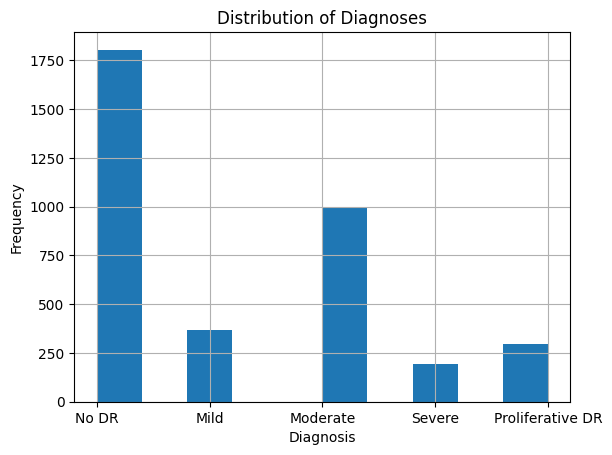

In [ ]:
train_df.diagnosis.hist()
plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.xticks(range(5), class_labels)
plt.show()

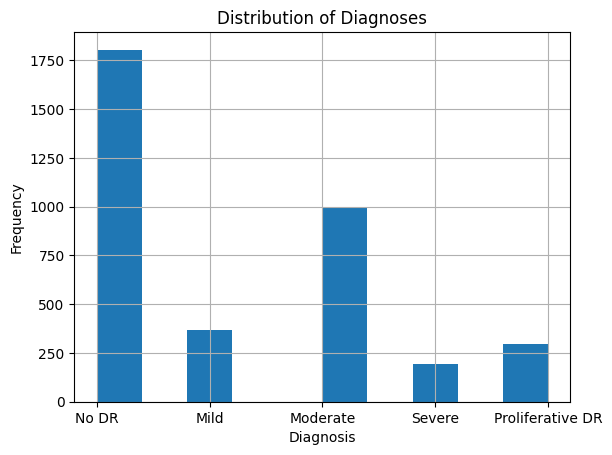

In [ ]:
train_df.diagnosis.hist()
plt.title('Distribution of Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.xticks(range(5), class_labels)
plt.show()


## Skip/ResNet & ViT_16/Vision Transformer Model Comparison 

In [ ]:
#Step 0: Install and Import Libraries
from torchvision.models import resnet50
from torchvision.models import resnet18
from torchvision.models import ViT_B_16_Weights
#from transformers import ViTFeatureExtractor, ViTModel
import torchvision.models as models
from torchvision.models import vision_transformer

from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.optim import Adam
#!pip install torch torchvision torchtext transformers
from transformers import ViTModel, ViTConfig

In [ ]:


import torchvision.transforms as T
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import requests
from io import BytesIO


In [ ]:
# Step 2: Load in Models
# Load ResNet-50 pretrained model
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 5) 
#backbone = nn.Sequential(*list(resnet.children())[:-1])

# load ViT-B/16
timm.list_models('vit_*')
timm.list_models('convnext*')

#vit_b_16 = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
convnext = timm.create_model('convnext_base', pretrained=True)

num_features = vit_model.head.in_features
vit_model.head = nn.Linear(num_features, 5)  

c:\Users\matth\anaconda3\envs\Computer-Vision\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matth\anaconda3\envs\Computer-Vision\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Step 4: Initialize Model and Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 5
num_epochs = 10

resnet = resnet.to(device)
vit_model = vit_model.to(device)

optimizer_resnet = Adam(resnet.parameters(), lr=0.0001)
optimizer_vit = Adam(vit_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(normalized_weights_tensor)) 
#criterion = nn.CrossEntropyLoss()

C:\Users\matth\AppData\Local\Temp\ipykernel_65288\1224613717.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criterion = nn.CrossEntropyLoss(weight=torch.tensor(normalized_weights_tensor))


## Train and Evaluate Models

In [ ]:
# Step 5: Preparing Model (Training)
def train_model(vit_model, train_dataloader, optimizer, criterion):
    num_epochs = 10
    running_loss = 0
    train_loss_list = []
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        vit_model.train()
        for images, labels in tqdm(train_dataloader, desc="Batches", leave=False):
            images, labels = images.to(device), labels.to(device)
            #print(f"Batch shape before model: {images.shape}")  # Add this line to check shape
            optimizer.zero_grad()
            output = vit_model(images)
            #print(output.keys())
            #last_hidden_state, pooler_output = vit_model(images) 
            #print(pooler_output.keys()) 
            #print(last_hidden_state, pooler_output = vit_model(images).keys()) 
            #outputs['last_hidden_state'], outputs['pooler_output']
        
            # Calculate loss
            #loss = criterion(pooler_output, labels)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_dataloader)
        train_loss_list.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")
    return train_loss_list

In [27]:
# Step 6: Evaluation (Validation and Testing)
def evaluate(model, loader):
    model.eval()
    total = 0
    correct = 0
    precision = 0
    recall = 0
    precision_list = []
    recall_list = []
    eval_lost_list = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            #loss = criterion(output, labels)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy
    

In [ ]:
#train_model(vit_model, train_dataloader, optimizer, criterion):
train_accuracy_vit = train_model(vit_model, train_dataloader, optimizer_vit, criterion)

Epochs:  10%|█         | 1/10 [06:44<1:00:40, 404.52s/it]

Epoch 1/10, Loss: 1.5451366836610048


Epochs:  20%|██        | 2/10 [13:33<54:18, 407.36s/it]  

Epoch 2/10, Loss: 2.894483188572137


Epochs:  30%|███       | 3/10 [20:52<49:10, 421.51s/it]

Epoch 3/10, Loss: 4.12395490122878


Epochs:  40%|████      | 4/10 [27:41<41:41, 416.86s/it]

Epoch 4/10, Loss: 5.287988125630047


Epochs:  50%|█████     | 5/10 [34:27<34:24, 412.84s/it]

Epoch 5/10, Loss: 6.370260717428249


Epochs:  60%|██████    | 6/10 [41:16<27:25, 411.31s/it]

Epoch 6/10, Loss: 7.355275621880656


Epochs:  70%|███████   | 7/10 [48:02<20:29, 409.72s/it]

Epoch 7/10, Loss: 8.274740099259045


Epochs:  80%|████████  | 8/10 [54:47<13:36, 408.23s/it]

Epoch 8/10, Loss: 9.131127946726654


Epochs:  90%|█████████ | 9/10 [1:50:12<22:00, 1320.15s/it]

Epoch 9/10, Loss: 9.907726635751517


Epochs: 100%|██████████| 10/10 [1:56:52<00:00, 701.26s/it] 

Epoch 10/10, Loss: 10.635080005811608


In [31]:
print(f'Training Accuracy ViT: {train_accuracy_vit}')

Training Accuracy ViT: [1.5451366836610048, 2.894483188572137, 4.12395490122878, 5.287988125630047, 6.370260717428249, 7.355275621880656, 8.274740099259045, 9.131127946726654, 9.907726635751517, 10.635080005811608]


In [ ]:
print(f'Training Accuracy ViT: {train_accuracy_vit}')

Training Accuracy ViT: [0.01416748346747008, 0.014167493712020968, 0.0141674943194054, 0.0141674943194054, 0.0141674943194054, 0.0141674943194054, 0.0141674943194054, 0.0141674943194054, 0.0141674943194054, 0.0141674943194054]


In [29]:
print(f'Training Accuracy ViT: {train_accuracy_vit}')

Training Accuracy ViT: [0.016625591718522438, 0.01662559196147621, 0.01662559196147621, 0.01662559196147621, 0.01662559196147621, 0.01662559196147621, 0.01662559196147621, 0.01662559196147621, 0.01662559196147621, 0.01662559196147621]


In [25]:
print(f'Training Accuracy ViT: {train_accuracy_vit}')

Training Accuracy ViT: [0.009851099145948769, 0.009851099145948769, 0.009851099145948769, 0.009851099145948769, 0.009851099145948769, 0.009851099145948769, 0.009851099145948769, 0.009851099145948769, 0.009851099145948769, 0.009851099145948769]


In [ ]:
#train_model(vit_model, train_dataloader, optimizer, criterion):
train_accuracy_resnet = train_model(resnet, train_dataloader, optimizer_resnet, criterion)

Epochs:  10%|█         | 1/10 [03:19<29:51, 199.01s/it]

Epoch 1/10, Loss: 1.5265774817570397


Epochs:  20%|██        | 2/10 [06:36<26:24, 198.01s/it]

Epoch 2/10, Loss: 2.882118170676024


Epochs:  30%|███       | 3/10 [09:55<23:09, 198.48s/it]

Epoch 3/10, Loss: 4.142230664906294


Epochs:  40%|████      | 4/10 [13:12<19:47, 197.95s/it]

Epoch 4/10, Loss: 5.3262811225393545


Epochs:  50%|█████     | 5/10 [16:30<16:30, 198.09s/it]

Epoch 5/10, Loss: 6.4697079503017925


Epochs:  60%|██████    | 6/10 [19:49<13:12, 198.17s/it]

Epoch 6/10, Loss: 7.5701106981090875


Epochs:  70%|███████   | 7/10 [23:06<09:53, 197.96s/it]

Epoch 7/10, Loss: 8.636629933896272


Epochs:  80%|████████  | 8/10 [26:24<06:35, 197.90s/it]

Epoch 8/10, Loss: 9.684803007089574


Epochs:  90%|█████████ | 9/10 [29:41<03:17, 197.71s/it]

Epoch 9/10, Loss: 10.701872425882712


Epochs: 100%|██████████| 10/10 [32:59<00:00, 197.99s/it]

Epoch 10/10, Loss: 11.703303496474804


In [29]:
print(f'Training Accuracy ResNet: {train_accuracy_resnet}')

Training Accuracy ResNet: [1.5265774817570397, 2.882118170676024, 4.142230664906294, 5.3262811225393545, 6.4697079503017925, 7.5701106981090875, 8.636629933896272, 9.684803007089574, 10.701872425882712, 11.703303496474804]


In [26]:
print(f'Training Accuracy ResNet: {train_accuracy_resnet}')

Training Accuracy ResNet: [0.20731830625268427, 0.21739506271526055, 0.22260907063331536, 0.22587993598047076, 0.22817076928533978, 0.22988634877306732, 0.2312241223597717, 0.23229870441908765, 0.23317574683523676, 0.23391374844599658]


In [31]:
print(f'Training Accuracy ResNet: {train_accuracy_resnet}')

Training Accuracy ResNet: [0.19221321138067413, 0.20182059150006945, 0.20676222807758124, 0.20988211394844414, 0.21205861058273434, 0.21367852264159845, 0.2149420759429315, 0.2159580630319871, 0.21680161087082842, 0.2175214642711976]


In [ ]:
val_accuracy_vit = evaluate(vit_model, val_dataloader)

#test_accuracy_vit = evaluate(vit_model, test_dataloader)
#print(f'Test Accuracy ViT: {test_accuracy_vit:.4f}')

In [ ]:
val_accuracy_resnet = evaluate(resnet, val_dataloader)

#test_accuracy_resnet = evaluate(resnet, test_dataloader)
#print(f'Test Accuracy ResNet: {test_accuracy_resnet:.4f}')

In [ ]:
print(val_accuracy_vit)
print(val_accuracy_resnet)

0.6834924965893588
0.6684856753069577


In [68]:
val_accuracy_vit = val_accuracy_vit * 100
val_accuracy_resnet = val_accuracy_resnet * 100
print(f"Accuracy After SMOTE & Balanced CE: {val_accuracy_vit:.2f}%")
print(f"Accuracy After SMOTE & Balanced CE: {val_accuracy_resnet:.2f}%")

Accuracy After SMOTE & Balanced CE: 68.35%
Accuracy After SMOTE & Balanced CE: 66.85%


## LIME

In [ ]:
def preprocess(img):
    return transform(Image.fromarray(img)).unsqueeze(0)

In [ ]:
def get_predict_fn(model):
    def predict(images):
        batch = torch.cat([preprocess(img) for img in images], dim=0)
        with torch.no_grad():
            logits = model(batch)
            probs = torch.nn.functional.softmax(logits, dim=1)
        #return probs.numpy()
        return probs.cpu().numpy() 
    return predict



In [ ]:
resnet_cpu = resnet.cpu().eval()
vit_model_cpu = vit_model.cpu().eval()

resnet_predict = get_predict_fn(resnet_cpu)
vit_predict = get_predict_fn(vit_model_cpu)


In [ ]:
img = Image.open("C:\\Users\\matth\\Documents\\CAP5516 - Medical Image Computing\\Med Final Project\\aptos2019-blindness-detection\\train_images\\000c1434d8d7.png")
img.show()
pixels = img.load()

#img = "\train_images\000c1434d8d7.png"
#print(img)

In [ ]:
explainer = lime_image.LimeImageExplainer()
orig_image = np.array(img)


In [ ]:
resnet_explanation = explainer.explain_instance(
    orig_image, 
    resnet_predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=300
)
resnet_img, resnet_mask = resnet_explanation.get_image_and_mask(
    resnet_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False
)



100%|██████████| 300/300 [1:43:13<00:00, 20.64s/it]


In [42]:
resnet_explanation

In [ ]:
vit_explanation = explainer.explain_instance(
    orig_image, 
    vit_predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=300
)
vit_img, vit_mask = vit_explanation.get_image_and_mask(
    vit_explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False
)


100%|██████████| 300/300 [1:51:12<00:00, 22.24s/it]


In [44]:
vit_explanation

In [ ]:
# ResNet Image
from skimage.segmentation import mark_boundaries


temp, mask = resnet_explanation.get_image_and_mask(
    label=resnet_explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)


image_with_boundaries = mark_boundaries(temp / 255.0, mask)
image_uint8 = (image_with_boundaries * 255).astype(np.uint8)
img = Image.fromarray(image_uint8)
img.save("lime_explanation_SMOTE_resnet.png")


In [ ]:
# VIT Image
from skimage.segmentation import mark_boundaries


temp, mask = vit_explanation.get_image_and_mask(
    label=vit_explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)


image_with_boundaries = mark_boundaries(temp / 255.0, mask)
image_uint8 = (image_with_boundaries * 255).astype(np.uint8)
img = Image.fromarray(image_uint8)
img.save("lime_explanation_SMOTE_vit.png")

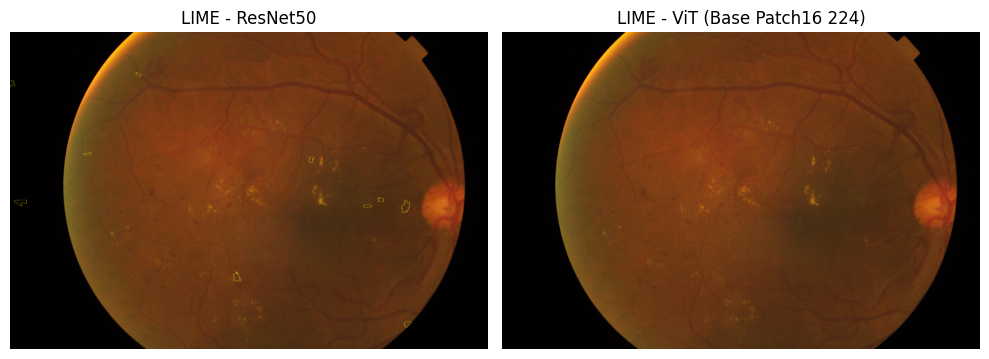

In [47]:

# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mark_boundaries(resnet_img / 255.0, resnet_mask))
ax[0].set_title("LIME - ResNet50")
ax[0].axis('off')

ax[1].imshow(mark_boundaries(vit_img / 255.0, vit_mask))
ax[1].set_title("LIME - ViT (Base Patch16 224)")
ax[1].axis('off')

plt.tight_layout()
plt.show()

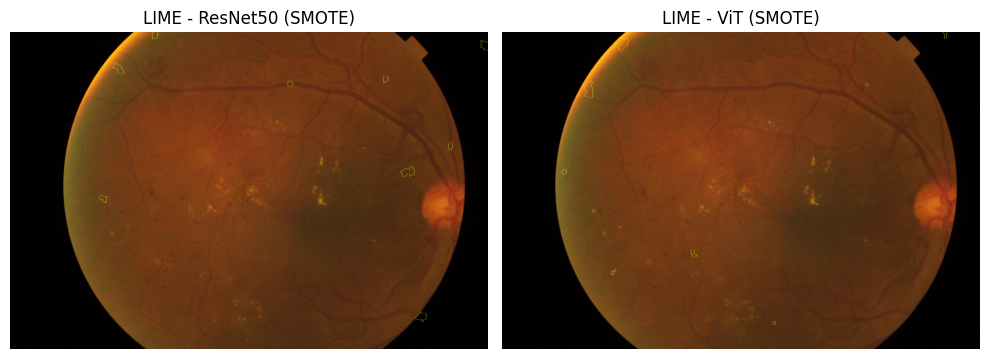

In [48]:
# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mark_boundaries(resnet_img / 255.0, resnet_mask))
ax[0].set_title("LIME - ResNet50 (SMOTE)")
ax[0].axis('off')

ax[1].imshow(mark_boundaries(vit_img / 255.0, vit_mask))
ax[1].set_title("LIME - ViT (SMOTE)")
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [53]:
from torch.utils.data import DataLoader, random_split
old_train_dataset = torchvision.datasets.ImageFolder(root='train_images', transform=transform)

old_train_size = int(0.8 * len(old_train_dataset))
old_val_size = len(old_train_dataset) - old_train_size
old_train_dataset, old_val_dataset = random_split(old_train_dataset, [old_train_size, old_val_size])

old_train_dataloader = DataLoader(old_train_dataset, batch_size=32, shuffle=True)
old_val_dataloader = DataLoader(old_val_dataset, batch_size=32, shuffle=False)

#print(len(train_dataloader))
#print(len(val_dataloader))

old_images, old_labels = next(iter(old_train_dataloader))
print("Train Labels Batch:", old_labels)

old_val_images, old_val_labels = next(iter(old_train_dataloader))
print("Validation Labels Batch:", old_val_labels)

old_accuracy = 1805.0/3662.0
old_accuracy = old_accuracy * 100
print(f"Accuracy Before SMOTE & Balanced CE: {old_accuracy:.2f}%")



Train Labels Batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Validation Labels Batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Accuracy Before SMOTE & Balanced CE: 49.29%


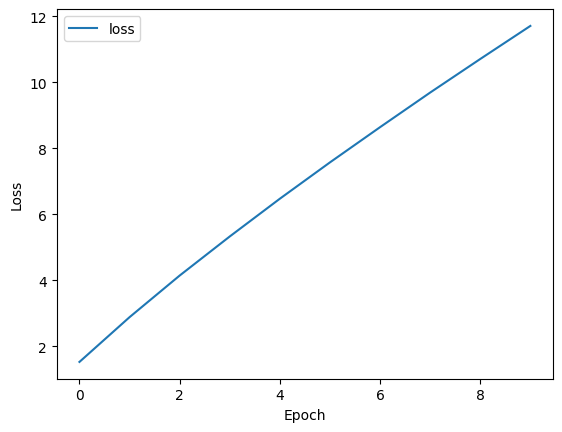

In [65]:
import matplotlib.pyplot as plt
fig = plt.figure()
#plt.plot(val_accuracy_resnet, label='val_accuracy')
plt.plot(train_accuracy_resnet, label='loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim([num_epochs-1, 0]) 
# plt.ylim([0.5, 1])
plt.legend()


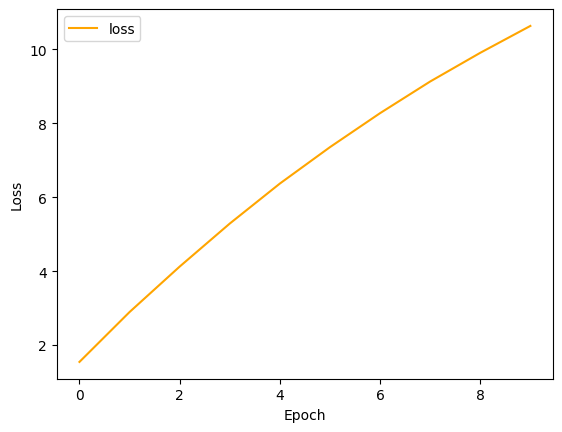

In [66]:
import matplotlib.pyplot as plt
fig = plt.figure()
#plt.plot(val_accuracy_resnet, label='val_accuracy')
plt.plot(train_accuracy_vit, label='loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim([num_epochs-1, 0]) 
# plt.ylim([0.5, 1])
plt.legend()

In [69]:
vit_model_path = 'vit_model_final.pth'
resnet_model_path = 'resnet_model_final.pth'

torch.save(vit_model.state_dict(), vit_model_path)
torch.save(resnet.state_dict(), resnet_model_path)

print(f"VIT Model saved to {vit_model_path}")
print(f"Resnet Model saved to {resnet_model_path}")

VIT Model saved to vit_model_final.pth
Resnet Model saved to resnet_model_final.pth


## Extras

In [ ]:
for images, labels in train_dataloader:
    train_image_shape = images.shape
    train_labels_shape = labels.shape
    break

for images, labels in val_dataloader:
    val_image_shape = images.shape
    val_labels_shape = labels.shape
    break

for images, labels in test_dataloader:
    test_image_shape = images.shape
    test_labels_shape = labels.shape
    break

In [ ]:
#!pip install imbalanced-learn torchvision timm
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
# Transform images to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset temporarily to extract features
dataset = CustomImageDataset(image_paths, labels, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np




X = []
y = []

for images, targets in train_dataloader:
    X.extend(images.view(images.size(0), -1).numpy())  # Flattened
    y.extend(targets.numpy())

X = np.array(X)
y = np.array(y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [57]:
unique_elements, counts = np.unique(targets, return_counts=True)

print("Unique elements:", unique_elements)
# Expected output: Unique elements: [1 2 3 4]
print("Counts:", counts)
# Expected output: Counts: [1 2 1 3]
print("Unique count:", len(unique_elements))

#print("Label distribution:", Counter(targets))

Unique elements: [0]
Counts: [17]
Unique count: 1


In [58]:
from collections import Counter
import torch

label_list = []

for _, labels in train_dataloader:
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    label_list.extend(labels)

# Now check unique labels and their counts
label_counts = Counter(label_list)
print("Label counts:", label_counts)

Label counts: Counter({np.int64(0): 2929})


In [ ]:
#transform = transforms.Compose([
    #transforms.Resize((224, 224)), 
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
#])

X_res_imgs = torch.tensor(X_res).view(-1, 3, 224, 224)  # If originally resized to 224x224

resampled_dataset = torch.utils.data.TensorDataset(X_res_imgs, torch.tensor(y_res))
resampled_loader = DataLoader(resampled_dataset, batch_size=32, shuffle=True)


In [ ]:
# Step 4: Initialize Model and Training Setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 5
num_epochs = 10

resnet_smote = resnet.to(device)
vit_model_smote = vit_model.to(device)

optimizer_resnet_smote = Adam(resnet.parameters(), lr=0.0001)
optimizer_vit_smote = Adam(vit_model.parameters(), lr=0.0001)
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(normalized_weights_tensor)) 
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_tensor)) 
criterion = nn.CrossEntropyLoss()

def train_model(vit_model, train_dataloader, optimizer, criterion):
    num_epochs = 10
    running_loss = 0
    train_loss_list = []
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        vit_model.train()
        for images, labels in tqdm(train_dataloader, desc="Batches", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = vit_model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_dataloader)
        train_loss_list.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")
    return train_loss_list

train_accuracy_vit = train_model(vit_model_smote, train_dataloader, optimizer_vit_smote, criterion)

train_accuracy_resnet = train_model(resnet_smote, train_dataloader, optimizer_resnet_smote, criterion)

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
import timm
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in resampled_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


## Batchees classifier

In [ ]:
import torch
import numpy as np

def classifier_fn(images):
    # Convert images to PyTorch tensor
    images = torch.tensor(images).float()

    # If you have a GPU, move images to the GPU
    images = images.cuda()

    # Assuming model is a pre-loaded PyTorch model
    model.eval()
    with torch.no_grad():
        output = model(images)

    # Get the probabilities (softmax is often used for classification)
    probabilities = torch.nn.functional.softmax(output, dim=1)

    # Convert to NumPy array and return
    return probabilities.numpy()


In [ ]:
from lime import lime_image
import torch
from torch.utils.data import DataLoader
import numpy as np

# Assuming you have a PyTorch DataLoader
#dataloader = DataLoader(train_datao, batch_size=32, shuffle=False)

# Set up the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Loop over batches from DataLoader
explanations = []
for i, (images, labels) in enumerate(train_loader):
    # Convert images to NumPy array (LIME expects NumPy)
    images_np = images.numpy()

    for j in range(len(images_np)):
        # Explain the prediction for each image in the batch
        explanation = explainer.explain_instance(
            image=images_np[j],                   # Single image
            classifier_fn=classifier_fn,          # The classifier function you defined
            top_labels=1,                         # Choose top label to explain
            hide_color=0,                         # Whether to hide the color when perturbing
            num_samples=100                      # Number of perturbed samples
        )

        # Save the explanation (you can save them to files or process them further)
        explanations.append(explanation)

        # Save image explanations
        temp, mask = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        # Overlay boundaries (if you want)
        from skimage.segmentation import mark_boundaries
        from PIL import Image
        img_overlay = mark_boundaries(temp / 255.0, mask)
        img_uint8 = (img_overlay * 255).astype(np.uint8)
        Image.fromarray(img_uint8).save(f'lime_explanation_batch_{i}_img_{j}.png')



In [ ]:
import os
from PIL import Image
import numpy as np
from lime import lime_image
import cv2

# Define the classifier_fn (assuming Keras/TensorFlow model for this example)
def classifier_fn(images):
    return model.predict(images)

# Setup LIME explainer
explainer = lime_image.LimeImageExplainer()

# Path to your image directory
image_dir = 'path/to/images'

# Loop over image files in the directory
explanations = []
for image_file in os.listdir(image_dir):
    if image_file.endswith(".jpg") or image_file.endswith(".png"):
        image_path = os.path.join(image_dir, image_file)
        
        # Load image (using OpenCV or Pillow)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Convert image to 4D batch (LIME expects a batch of images)
        image_batch = np.expand_dims(image, axis=0)

        # Explain the instance
        explanation = explainer.explain_instance(
            image=image,                          # The single image
            classifier_fn=classifier_fn,           # Classifier function
            top_labels=1,                          # Choose top label
            hide_color=0,                          # For perturbations
            num_samples=1000                       # Number of samples
        )

        explanations.append(explanation)

        # Save or visualize the explanation as shown earlier
        temp, mask = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        # Overlay and save the image explanation
        img_overlay = mark_boundaries(temp / 255.0, mask)
        img_uint8 = (img_overlay * 255).astype(np.uint8)
        Image.fromarray(img_uint8).save(f'lime_explanation_{image_file}.png')



## Extras

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [ ]:
predictions = rfc.predict(X_train)
print(classification_report(y_test, y_pred))

print()
print("accuracy_score", accuracy_score(y_test, y_pred))

rfc_cm=confusion_matrix(y_test,y_pred)
print("Confusion matrix of the model \n",rfc_cm)

print()
y_pred_proba = rfc.predict_proba(X_test)
print("roc-auc score for the class 1, from target 'HasDetections' ", roc_auc_score(y_test, y_pred_proba[:,1]))

print()
y_pred_proba = rfc.predict_proba(X_test)
print("roc-auc score for the class 0, from target 'HasDetections' ", roc_auc_score(y_test, y_pred_proba[:,0]))

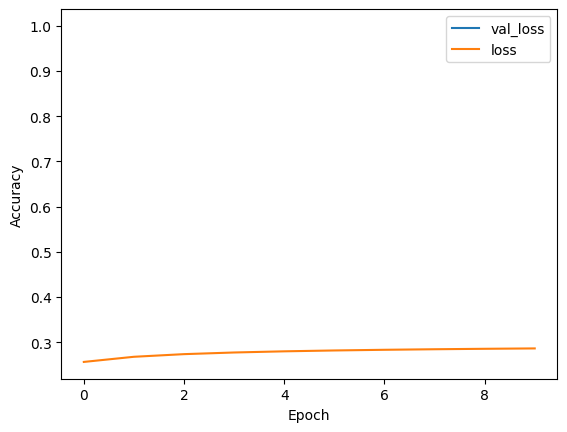

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(val_accuracy_resnet, label='val_accuracy')
plt.plot(train_accuracy_resnet, label='accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(val_accuracy_resnet, label='val_accuracy')
plt.plot(train_accuracy_resnet, label='accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()


/train_images/000c1434d8d7.png


In [46]:
#!pip install shap
import shap
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Create SHAP explainer
explainer = shap.Explainer(model, torchvision.transforms.Compose([
    torchvision.transforms.Resize((384, 384)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]))

# Compute SHAP values
shap_values = explainer(img)

# Visualize SHAP values (example)
shap.image_plot(shap_values)

RuntimeError: Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Get predictions for the validation set
y_pred_probs = model.predict(X_val)  # Predicted probabilities
y_pred = y_pred_probs.argmax(axis=1)  # Convert to predicted class indices

# Calculate precision and recall
precision = precision_score(y_val, y_pred, average='weighted')  # Weighted for multiclass
recall = recall_score(y_val, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

In [ ]:
import torch

# Assuming 'model' is your trained PyTorch model
torch.save(resnet.state_dict(), 'resnet.pth')
torch.save(vit_model.state_dict(), 'vit_model.pth')

#Save models and not parameters
#torch.save(resnet.state_dict(), 'resnet.pth')
#torch.save(vit_model, 'vit_model.pth')
#resnet.save('resnet_model.h5')
#vit_model.save('vit_model.h5')


## Transfer Learning -> Vision Transformer